# Time Series Forecasting of Energy Consumption Using XGBoost: A Comprehensive Methodology  

This notebook presents an end-to-end workflow for applying gradient-boosted decision trees to predict hourly energy consumption patterns. By combining temporal feature engineering with XGBoost's advanced regression capabilities, we demonstrate a robust approach to time series forecasting that accounts for seasonal patterns, autoregressive dependencies, and calendar effects. Our analysis of PJM Interconnection's historical load data (2002-2018) reveals XGBoost's effectiveness in handling complex energy forecasting challenges while maintaining computational efficiency.  

---

## Foundational Concepts in Modern Time Series Forecasting  

### The Evolution of Energy Demand Prediction  
Time series forecasting has become indispensable in energy grid management, where accurate predictions directly impact operational efficiency and infrastructure planning. Traditional statistical methods like ARIMA dominated early forecasting efforts through their explicit modeling of autocorrelation and differencing components. However, the machine learning revolution introduced new paradigms for handling:  

1. **High-dimensional feature spaces** through automatic relevance detection  
2. **Non-linear relationships** via hierarchical decision trees  
3. **Missing data robustness** using built-in imputation strategies  

XGBoost emerged as particularly effective for energy forecasting due to its native support for:  
- Custom objective functions for asymmetric loss scenarios  
- Early stopping to prevent overfitting on large temporal datasets  
- Built-in feature importance calculations for operational insights



In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

In [47]:
df = pd.read_csv('data\PJME_hourly.csv')
df


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [49]:
df.Datetime = pd.to_datetime(df.Datetime)

In [50]:
df = df.set_index('Datetime')

In [51]:
df.isna().sum()

PJME_MW    0
dtype: int64

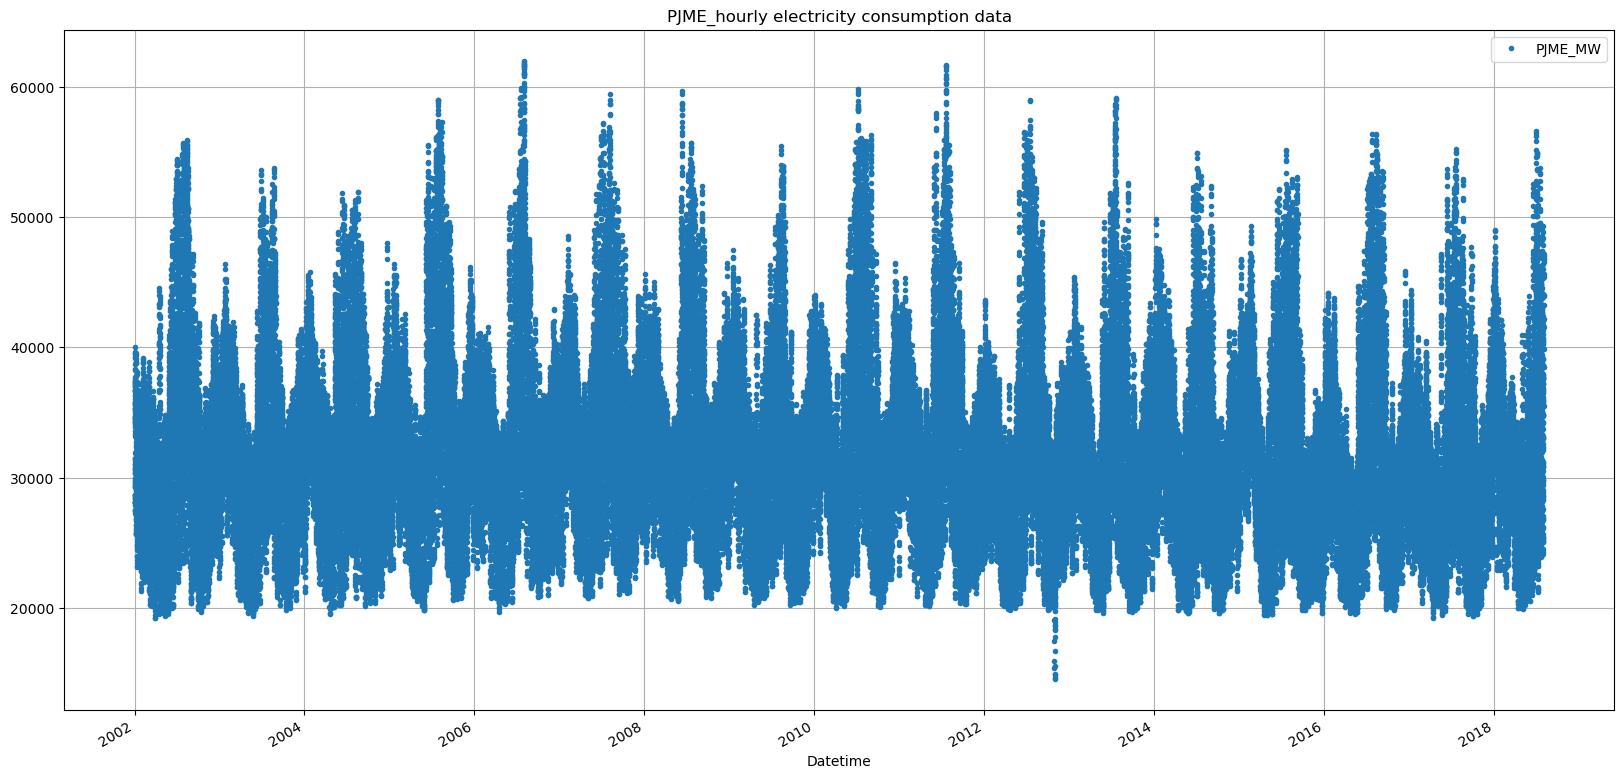

In [52]:
df.plot(style=".",
        figsize=(20,10),
        title='PJME_hourly electricity consumption data')
plt.grid(True)
plt.show()

# Outlier Analysis and removal

<Axes: ylabel='Frequency'>

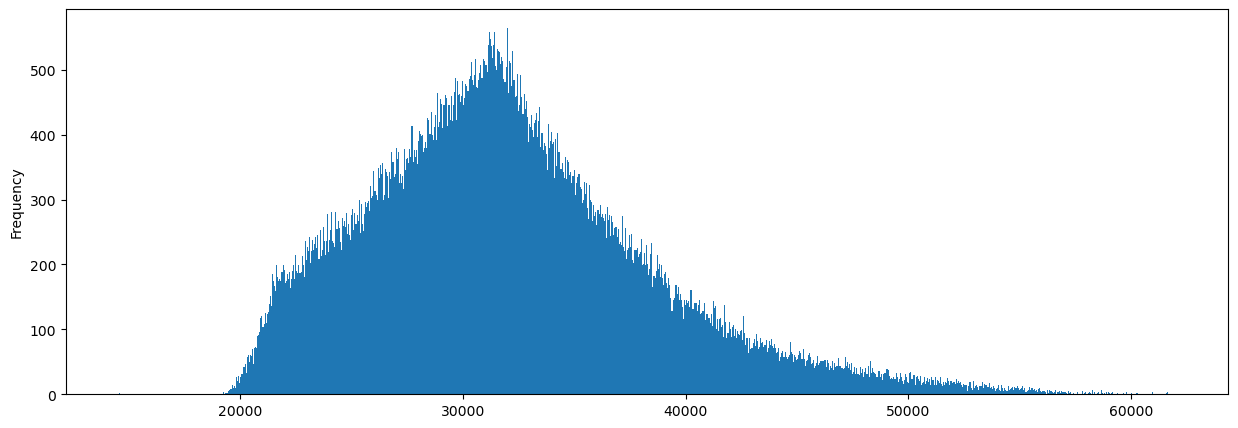

In [53]:

df['PJME_MW'].plot(figsize=(15,5),kind='hist', bins=1000)


<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

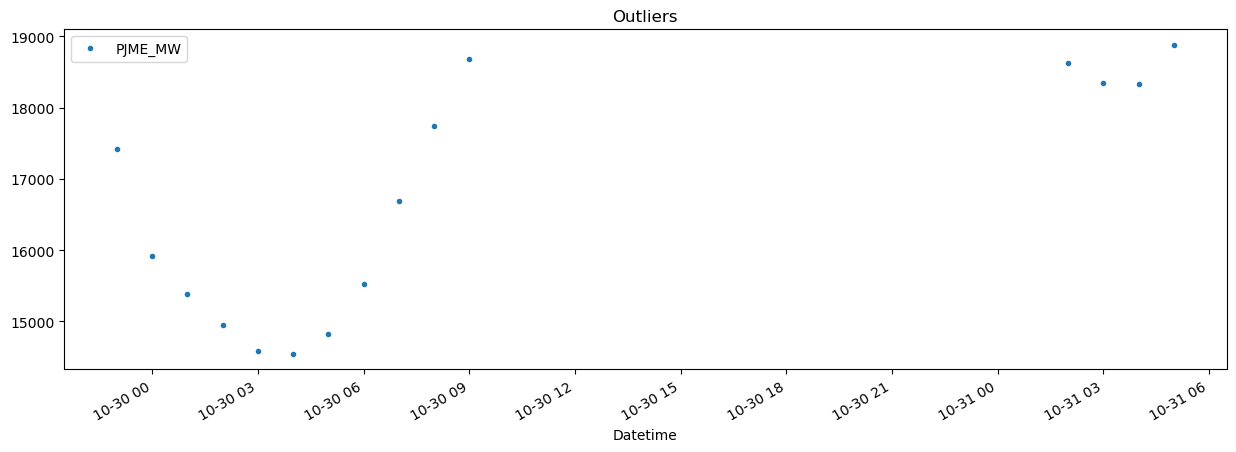

In [54]:
df.query('PJME_MW< 19_000').plot(figsize=(15,5), style=".", title="Outliers")

In [55]:
df = df.query('PJME_MW > 19_000').copy()

# Train / Test Split

In [56]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

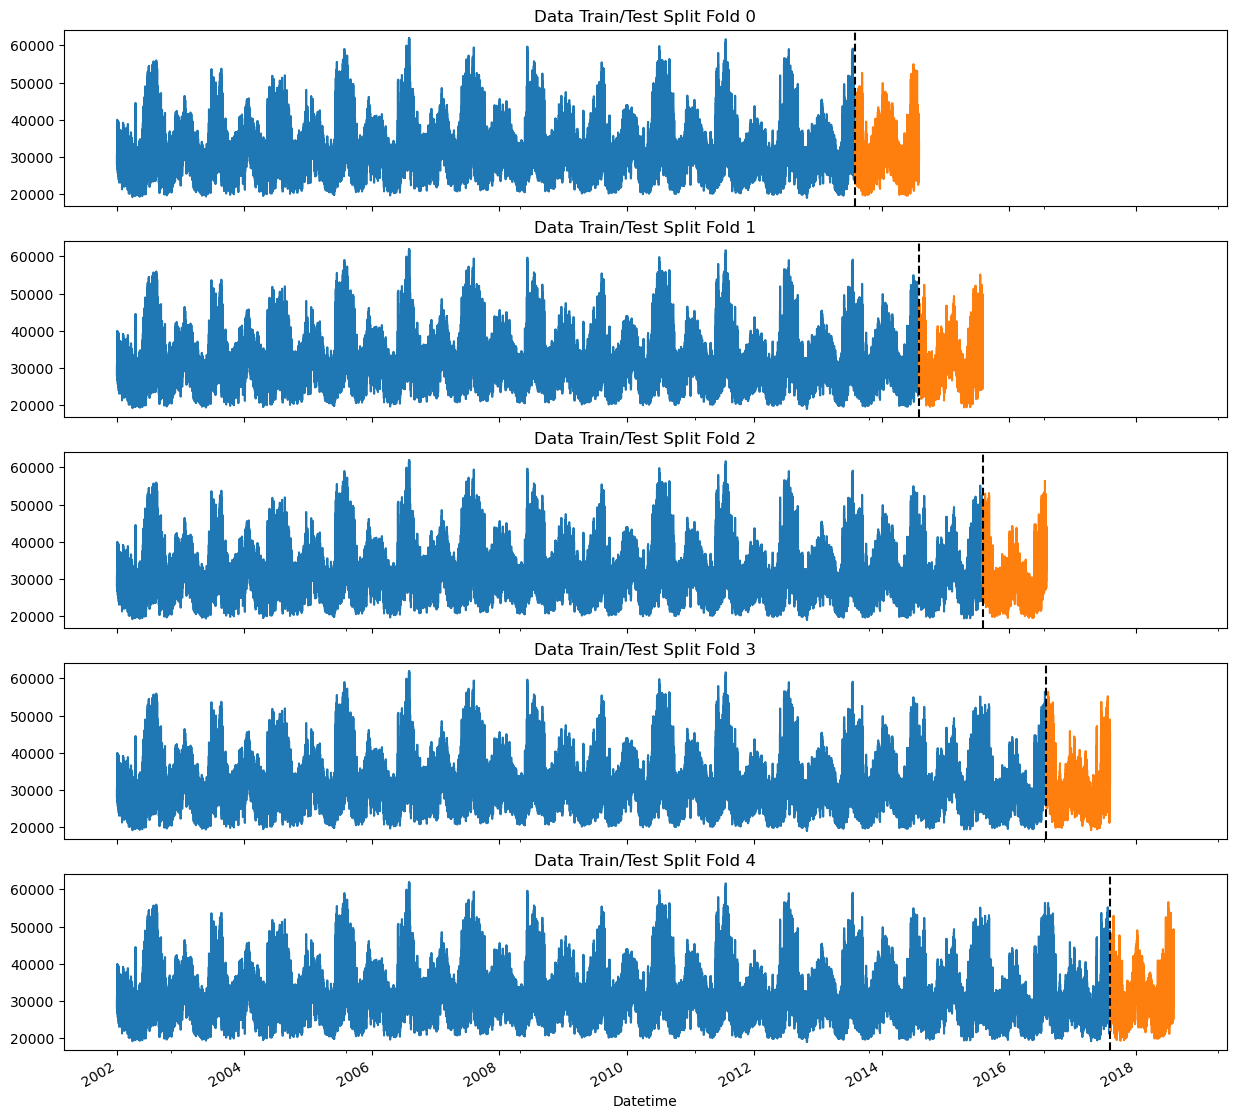

In [57]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

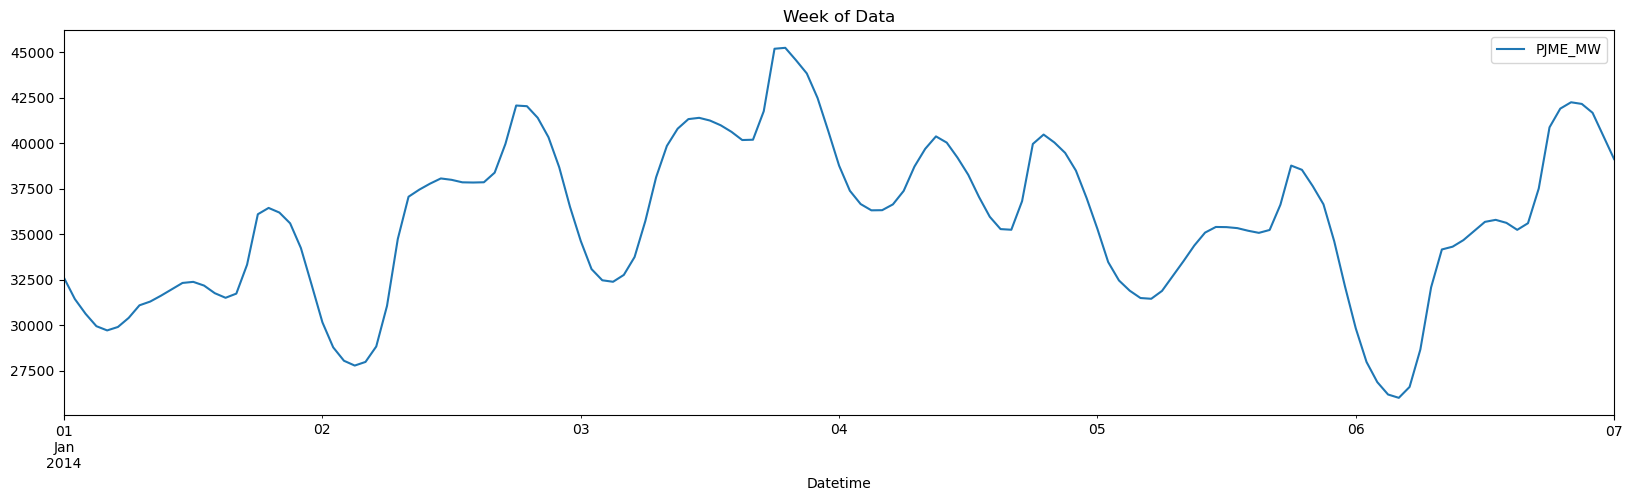

In [58]:
df.loc[(df.index >= '2014-01-01') & (df.index <= '2014-01-07')] \
    .sort_index() \
    .plot(figsize=(20, 5), title='Week of Data')
plt.show()


# Forecasting Horizon 
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [59]:
def create_features(df):
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = df['dayofweek'].isin([5, 6]) * 2
    return df
df = create_features(df)

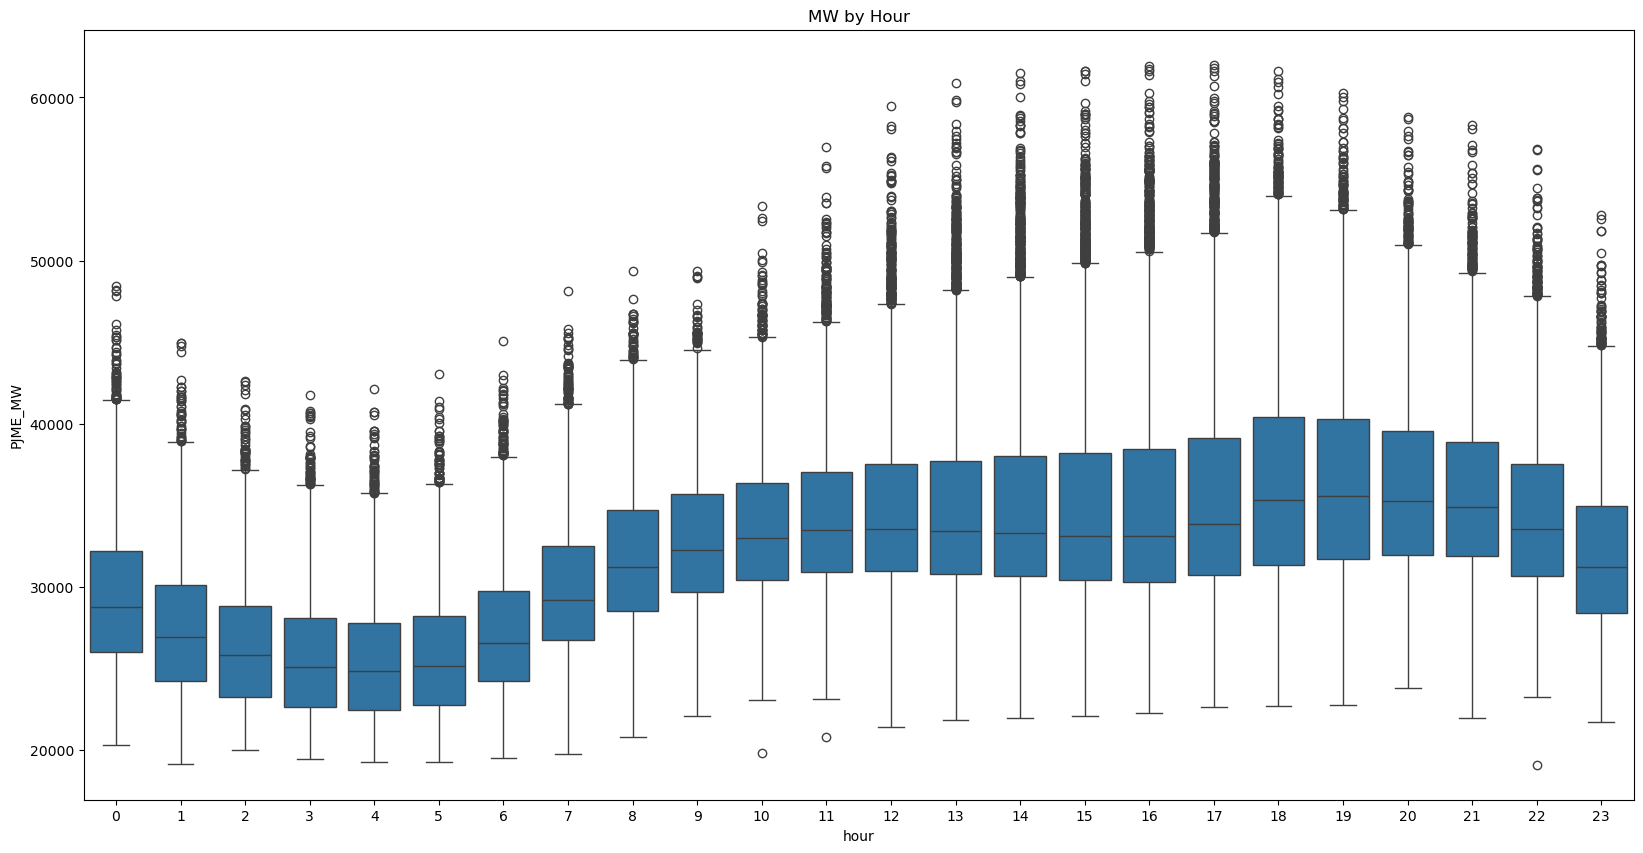

In [60]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

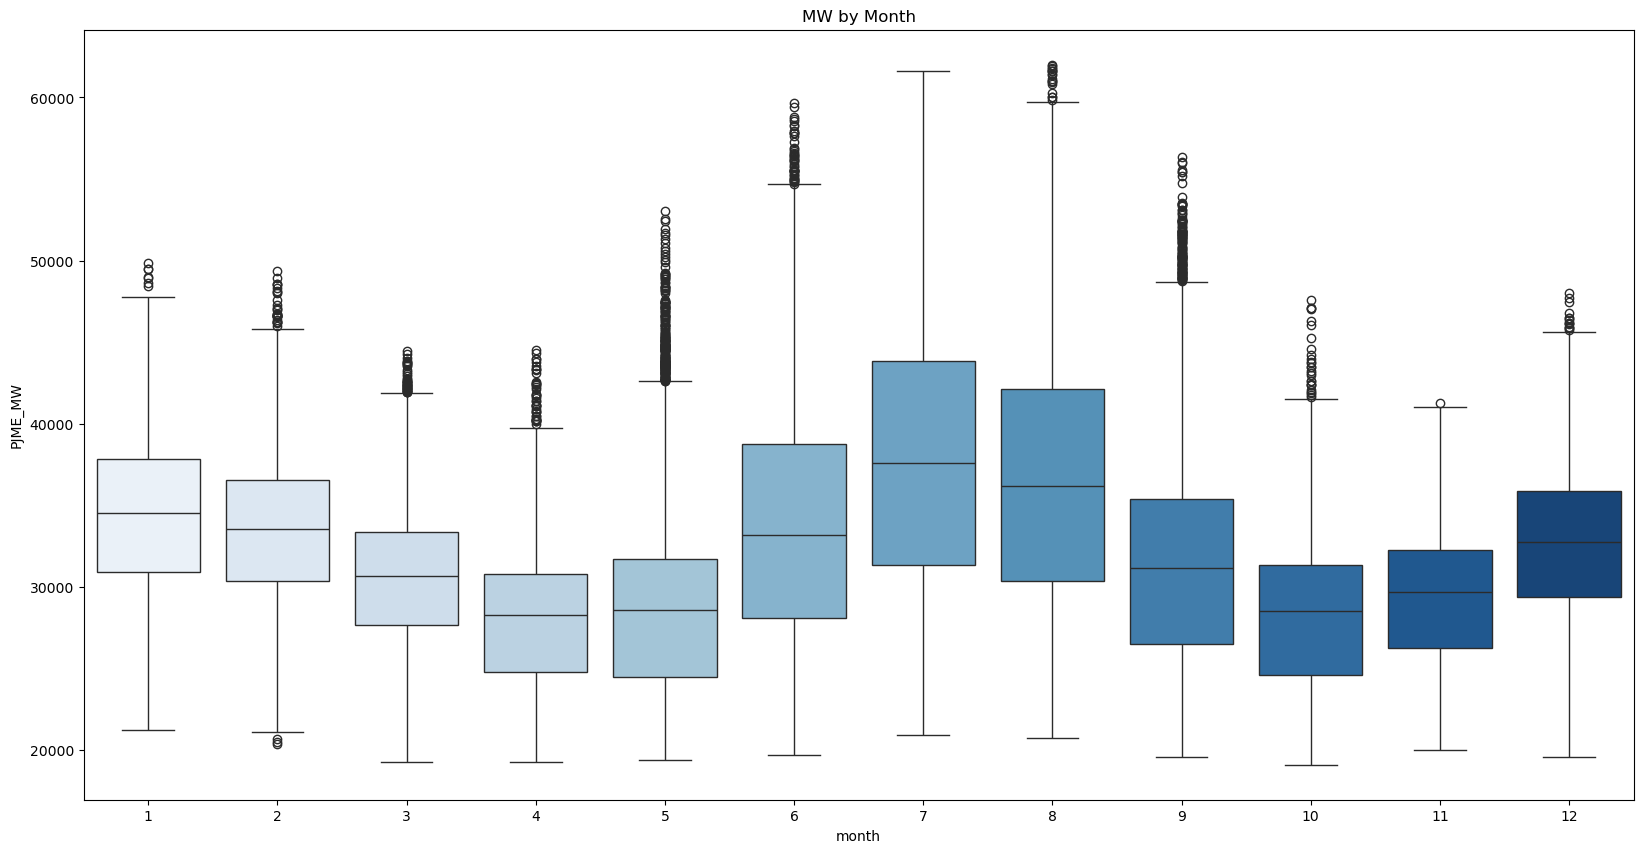

In [61]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Lag Features
- What was the target (x) days in the past.

In [62]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [63]:
df = add_lags(df)

In [64]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,0,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,0,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,0,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,0,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,0,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,0,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,0,39525.0,38698.0,37330.0


# Train Using Cross Validation

In [65]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163
[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241
[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	v

In [66]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


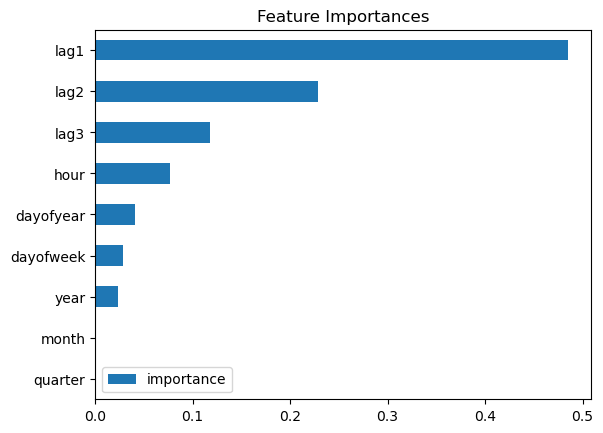

In [67]:
fi = pd.DataFrame(data= reg.feature_importances_,
                  index= reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values("importance").plot(kind='barh',title='Feature Importances')
plt.show()

#  Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [68]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991
[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [69]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [70]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [71]:
future_w_features = df_and_future.query('isFuture').copy()

In [72]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

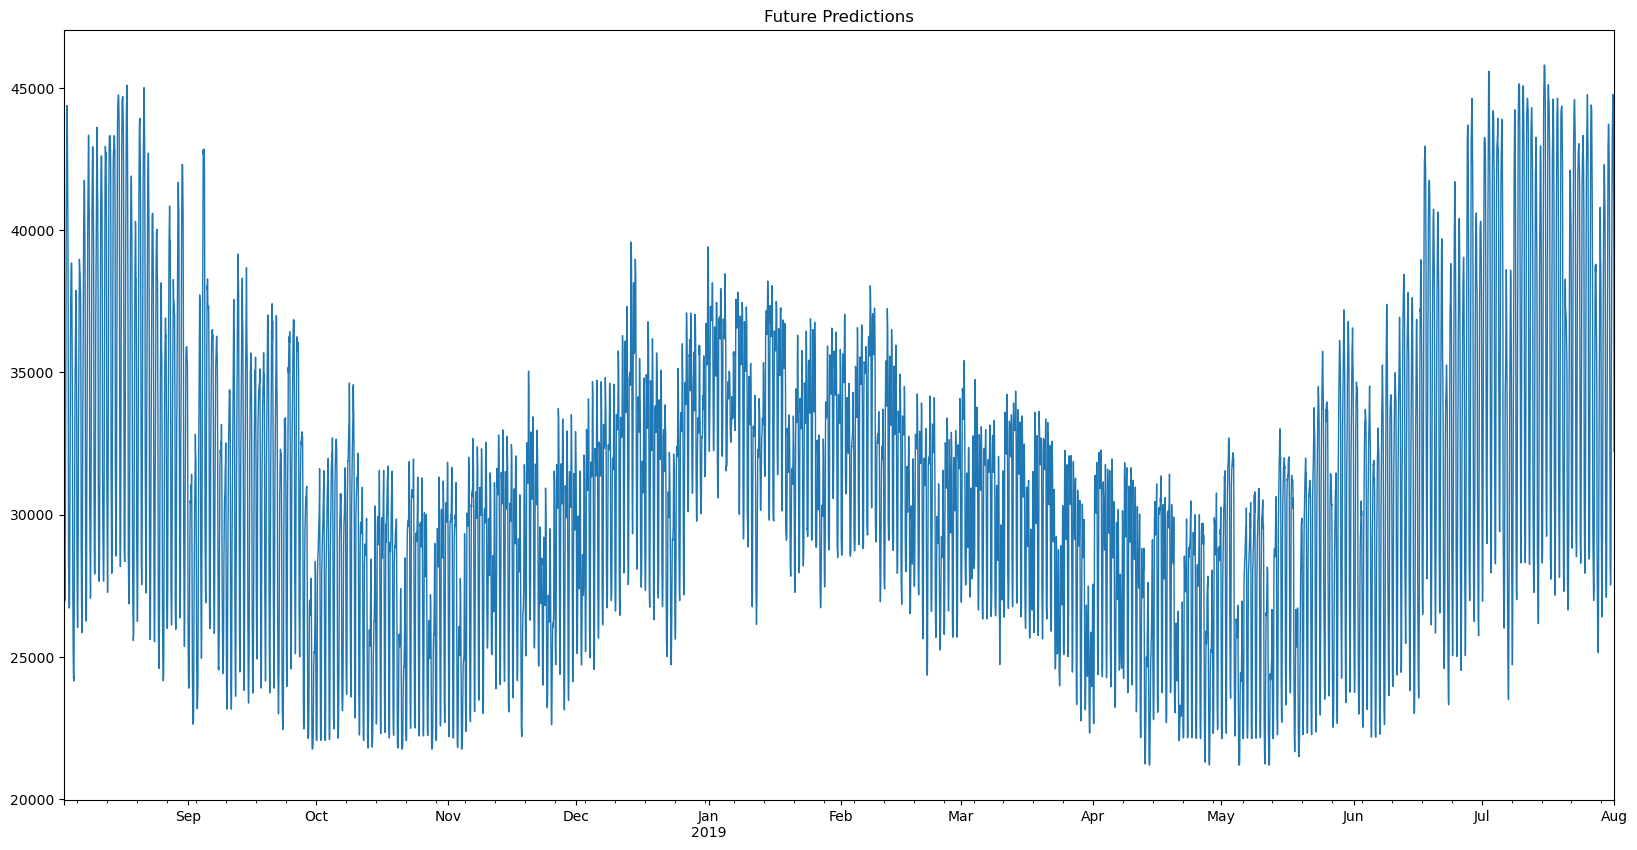

In [73]:
future_w_features['pred'].plot(figsize=(20, 10),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Saving Model For later

In [74]:
# Save model
reg.save_model('model.json')

# test the model

<Axes: title={'center': 'Future Predictions'}>

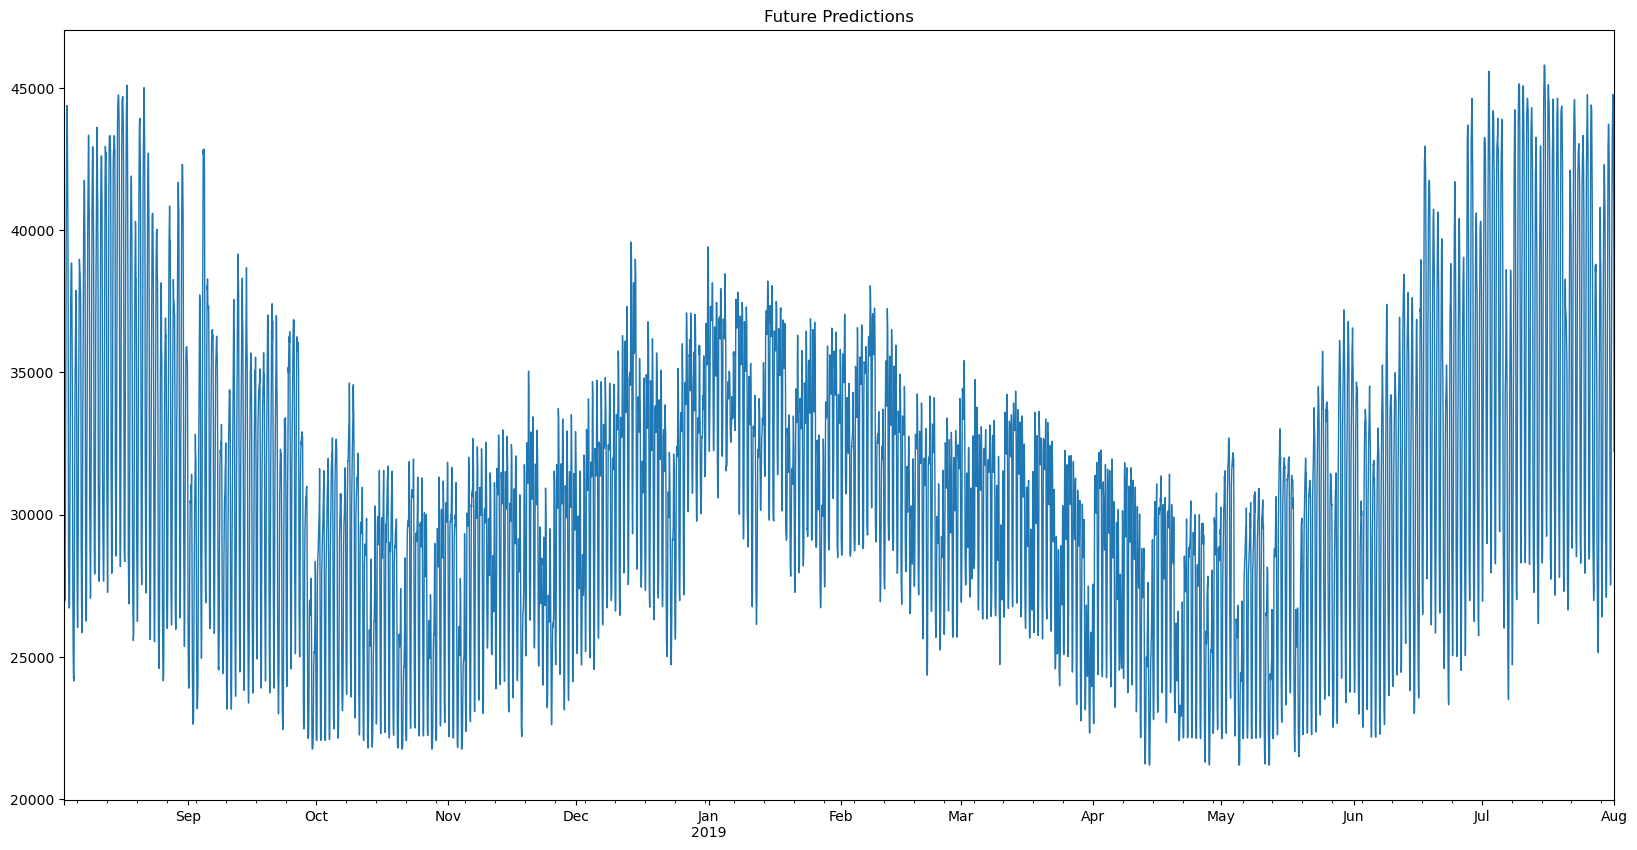

In [75]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(20, 10),
                               ms=1, lw=1,
                               title='Future Predictions')